# Question 1: Supervised learning - Random Forest

In this file we will try to learn a classifier to infer the skin colors of the player, utilizing the *CrowdstormingDataJuly1st.csv* dataset. We will:

- Preprocess the dataset so that the attributes are the one we need in the way we want. We will remove some features and we will add some others to obtain better predictions.
- We will train the Random Forest classifier with different parameter sets and we will see the results obtained to study the overfitting issue.
- We will present the results obtained with cross-validation.
- Analysis of the features\_importantances\_ parameter
- Study if the results change removing some features.

BONUS TASK:

- Learning curves with different sets of parameters in the cross-validation case.


    

# BONUS implementation - IMPORTANT

The learning curves are implemented in the *training parameters* section. We inserted the bonus tasks in this part to maintain the cronological order of the operations that we did. We found less clear to use a separate section for the Bonus part.

# Dataset importation
At first, we import the dataset in csv format.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
import time

In [3]:
data = pd.read_csv('CrowdstormingDataJuly1st.csv')
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


## Eliminating missing data

**COMMENTS**

Since some labels are missing, we will only consider the players with both ratings, for the training dataset. In the follwing we will verify that each player has got either both ratings or none of them (that is, the invalid entries affect both *rater1* and *rater2*):

In [12]:
data_one_rater2 = data[data.rater2.isnull() & ~data.rater1.isnull()]
data_one_rater1 = data[data.rater1.isnull() & ~data.rater2.isnull()]
print('There are '+str(len(data_one_rater2)+len(data_one_rater1))+
      ' player(s) with a single rating missing.')
print('Out of '+str(data.shape[0])+' data entries, we will only consider '+
      str(rater_data.shape[0])+' of them, i.e. '+str(rater_data.shape[0]*
                                                        100/data.shape[0])
      +'% of the entries, because of '+str(missing_rater_data.shape[0])+
      ' entries for which the skin color has not been rated.')

There are 0 player(s) with a single rating missing.
Out of 146028 data entries, we will only consider 124621 of them, i.e. 85.34048264716355% of the entries, because of 21407 entries for which the skin color has not been rated.


# Preprocessing

**COMMENTS**

For convenience we splitted the preprocessing part in 2 functions.
We will:
 - Delete the columns photoID, victories, ties, defeats, Alpha_3, club, goals. We suppose that these variables are *not correlated* with the skin color of the player;
 - Delete all the rows corresponding to a referee with less than 22 entry (all premier League players are included, so each referee must have met all 22 players of both teams during a match);
 - Remove less significant referee entry (with nIAT and nExp too low: qualitative threshold to filter not converged mean parameters). This is done in preprocess_2

In [54]:
def preprocess_1(database,remove_bad_referee=True,nIAT_threshold=50,nExp_threshold=50):
    train=database.copy()
    
    # Delete unused features
    del train['photoID']
    del train['victories']
    del train['ties']
    del train['defeats']
    del train['Alpha_3']
    del train['club']
    del train['goals']

    # Remove diads with a referee with less than 22 entries
    train_group=train.groupby(train.refNum)
    if remove_bad_referee:
        for i,group in train_group:
            if group.shape[0]<22:
                train=train.drop(train_group.get_group(i).index)
            if i%500==0:
                print(i)
    
   
    return train

In [55]:
train_after_prep_1=preprocess_1(rater_data,remove_bad_referee=True)

500
1000
1500
2000
2500
3000


In [56]:
def preprocess_2(database,nIAT_threshold=50,nExp_threshold=50):
    train=database.copy()
    train_group=database.groupby(train.refNum)

    for i,group in train_group:
        if group.nIAT.iloc[0]<nIAT_threshold or group.nExp.iloc[0]<nExp_threshold:
            train=train.drop(train_group.get_group(i).index)
        if i%200==0:
            print(i)
    return train

In [57]:
train_after_prep_2=preprocess_2(train_after_prep_1)

1600
2400
3000


In [58]:
train_after_prep_2.shape

(111533, 21)

In [59]:
train_after_prep_2.ix[:,:11].head(3)

,playerShort,player,leagueCountry,birthday,height,weight,position,games,yellowCards,yellowReds,redCards
5,aaron-hughes,Aaron Hughes,England,08.11.1979,182.0,71.0,Center Back,1,0,0,0
6,aleksandar-kolarov,Aleksandar Kolarov,England,10.11.1985,187.0,80.0,Left Fullback,1,0,0,0
7,alexander-tettey,Alexander Tettey,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,0,0


In [60]:
train_after_prep_2.ix[:,11:].head(3)

,rater1,rater2,refNum,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
5,0.25,0.00,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,0.00,0.25,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752
7,1.00,1.00,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752


# Random forest with referee information

**COMMENTS**

We trained a Random Forest classifier to predict the player skin color.

Operations done:
 - Keep only the wanted features: ['playerShort','leagueCountry','birthday','height','weight','position','games','club','yellowCards','redCards','yellowReds','meanIAT','meanExp','rater1','rater2']
 - Fill NaN with **median** of the columns
 - Keep only the year of birth (not the date)
 - Add dummy variables for the categorical variables
 - Keep one entry for player
 - Extract y as **mean of rater1 and rater2**
 - y as binary variable -> threshold set at **0.3**

### Binary y
As said, we chosed to use a binary y. We chosed as threshold 0.3.

## Train and test split - adding features

**COMMENTS**

We add some transformed features starting from the available ones, trying to define eventually more significant parameters:
 - *meanYellowPlayer*: the mean of the yellow cards obtained by each player
 - *meanYellowPlayerIAT*: the mean of the yellow cards obtained by each player weighted with the IAT statistics of the referee
 - *meanYellowPlayerExp*: the mean of the yellow cards obtained by each player weighted with the Exp statistics of the referee
 - *meanYellowRole*: the mean of yellow cards obtained by the player in a particular role
 - *meanYellowRoleIAT*: the mean of yellow cards obtained by the player in a particular role weighted with the IAT statistics of the referee
 - *meanYellowRoleExp*: the mean of yellow cards obtained by the player in a particular role weighted with the Exp statistics of the referee
 - *yellowDifference*: difference between meanYellowPlayer and meanYellowRole
 - *yellowDifferenceIAT*: difference between meanYellowPlayerIAT and meanYellowRoleIAT
 - *yellowDifferenceExp*: difference between meanYellowPlayerExp and meanYellowRoleExp
 
The same features have been added for red and yellowRed cards.

Dummy features:
- leagueCountry
- position

The function _add\_mean\_player()_ adds the mean of the player features.
The function _add\_mean\_player()_ adds the mean of yellow/red/yellowReds cards for each role.

In [29]:
def add_mean_player(x):
    x_games=sum(x.games)
    x['meanYellowPlayer']=sum(x.yellowCards)/x_games
    x['meanRedPlayer']=sum(x.redCards)/x_games
    x['meanYellowRedPlayer']=sum(x.yellowReds)/x_games
    
    x['meanYellowPlayerIAT']=sum(x.yellowCards*x.meanIAT)/x_games
    x['meanRedPlayerIAT']=sum(x.redCards*x.meanIAT)/x_games
    x['meanYellowRedPlayerIAT']=sum(x.yellowReds*x.meanIAT)/x_games
    
    x['meanYellowPlayerExp']=sum(x.yellowCards*x.meanExp)/x_games
    x['meanRedPlayerExp']=sum(x.redCards*x.meanExp)/x_games
    x['meanYellowRedPlayerExp']=sum(x.yellowReds*x.meanExp)/x_games
    
    return x

In [30]:
def add_mean_role(x,train_database_grouped=False,is_train=True):
    if is_train:
        
        x['meanYellowRole']=sum(x.yellowCards)/sum(x.games)
        x['meanRedRole']=sum(x.redCards)/sum(x.games)
        x['meanYellowRedRole']=sum(x.yellowReds)/sum(x.games)

        x['meanYellowRoleIAT']=sum(x.yellowCards*x.meanIAT)/sum(x.games)
        x['meanRedRoleIAT']=sum(x.redCards*x.meanIAT)/sum(x.games)
        x['meanYellowRedRoleIAT']=sum(x.yellowReds*x.meanIAT)/sum(x.games)

        x['meanYellowRoleExp']=sum(x.yellowCards*x.meanExp)/sum(x.games)
        x['meanRedRoleExp']=sum(x.redCards*x.meanExp)/sum(x.games)
        x['meanYellowRedRoleExp']=sum(x.yellowReds*x.meanExp)/sum(x.games)
    else:
        position=x.position.iloc[0]
        leagueCountry=x.leagueCountry.iloc[0]
        group=train_database_grouped.loc[position]
        x['meanYellowRole']=group.loc['meanYellowRole']
        x['meanRedRole']=group.loc['meanRedRole']
        x['meanYellowRedRole']=group.loc['meanYellowRedRole']

        x['meanYellowRoleIAT']=group.loc['meanYellowRoleIAT']
        x['meanRedRoleIAT']=group.loc['meanRedRoleIAT']
        x['meanYellowRedRoleIAT']=group.loc['meanYellowRedRoleIAT']

        x['meanYellowRoleExp']=group.loc['meanYellowRoleExp']
        x['meanRedRoleExp']=group.loc['meanRedRoleExp']
        x['meanYellowRedRoleExp']=group.loc['meanYellowRedRoleExp']
    return x

The following features are eliminated since there should be no correlation with the player skin color

In [62]:
features_to_eliminate=['games', 'yellowCards', 'redCards',
       'yellowReds', 'meanIAT', 'meanExp', 'meanYellowRole',
       'meanRedRole', 'meanYellowRedRole', 'meanYellowRoleIAT',
       'meanRedRoleIAT', 'meanYellowRedRoleIAT', 'meanYellowRoleExp',
       'meanRedRoleExp', 'meanYellowRedRoleExp']

The _process\_database()_ function, given the starting database, returns the split in train and test and adds the previously described features.

This function *has to be called* at each evaluation: some added features are database dependents (like the mean of the role ones).

In [66]:
def process_database(starting_database,train_indexes=True,test=False,binary_y=False):
    ''' Function that takes the preprocessed database and outputs train, test and y
        @ params:
            starting_database - the preprocessed database
            train_indexes - the indexes of the player to be inserted in the training 
                            (the PLAYER INDEXES, not the indexes of the full database)
            test - if considering also a test matrix
            binary_y - if considering a binary (0-1) y
                            
        @ returns:
            train
            test
            y
    '''
    
    
    number_of_players=len(starting_database.playerShort.value_counts())
    if test==False:
        train_indexes=np.range(starting_database.shape[0])
        test_indexes=[]
    else:
        small_database=starting_database.groupby('playerShort').mean()
        small_database=small_database.iloc[train_indexes]
        train_indexes=np.array(starting_database[starting_database.playerShort.isin(small_database.index)].index)
        test_indexes=np.array(starting_database.index)
        test_indexes=np.setdiff1d(test_indexes,train_indexes)
    t1=time.time()
    
    # Keep only wanted features - remove nan
    database=starting_database[['playerShort','leagueCountry','birthday','height','weight','position','games','yellowCards','redCards','yellowReds','meanIAT','meanExp','rater1','rater2']]
    database.is_copy=False
    database.position.fillna('nan',inplace=True)
    database.leagueCountry.fillna('nan',inplace=True)
    
    database=database.fillna(database.loc[train_indexes].median())

    # Process birthday to keep only the year
    database.birthday=database.birthday.apply(lambda x: int(x.split('.')[2]))
    
    # Add features - mean yellow cards per match of each player and the same quantity weighted with IAT and Exp
    database=database.groupby('playerShort').apply(add_mean_player)

    # Add features - mean yellow cards per role (also the weighted quantity)
    train_grouped=database.loc[train_indexes].groupby(['position']).apply(add_mean_role)
    train_grouped=train_grouped.groupby(['position']).first()
    database=database.groupby(['position']).apply(lambda x: add_mean_role(x,train_grouped,False))

    # Difference of added features 
    database['yellowDifference']=database.meanYellowPlayer-database.meanYellowRole
    database['redDifference']=database.meanRedPlayer-database.meanRedRole
    database['yellowRedDifference']=database.meanYellowRedPlayer-database.meanYellowRedRole
    
    database['yellowDifferenceIAT']=database.meanYellowPlayerIAT-database.meanYellowRoleIAT
    database['redDifferenceIAT']=database.meanRedPlayerIAT-database.meanRedRoleIAT
    database['yellowRedDifferenceIAT']=database.meanYellowRedPlayerIAT-database.meanYellowRedRoleIAT
    
    database['yellowDifferenceExp']=database.meanYellowPlayerExp-database.meanYellowRoleExp
    database['redDifferenceExp']=database.meanRedPlayerExp-database.meanRedRoleExp
    database['yellowRedDifferenceExp']=database.meanYellowRedPlayerExp-database.meanYellowRedRoleExp
    
    # Dummy variables
    dummy_variables=pd.get_dummies(database[['position','leagueCountry']])
    database=pd.concat([database,dummy_variables],axis=1)
    del database['leagueCountry']
    del database['position']
    
    # Split train e test
    train=database.loc[train_indexes]
    test=database.loc[test_indexes]
    
    # Extract one row per player
    train=train.groupby('playerShort').mean()
    test=test.groupby('playerShort').mean()
    
    # Get y and delete the columns in the train
    y_train=(train['rater1']+train['rater2'])/2
    y_test=(test['rater1']+test['rater2'])/2
    del train['rater1']
    del train['rater2']
    del test['rater1']
    del test['rater2']
    train=train.drop(features_to_eliminate,axis=1)
    test=test.drop(features_to_eliminate,axis=1)

    
    # y assumes only 0-1 values
    if binary_y:
        y_train=1*(y_train>0.3)
        y_test=1*(y_test>0.3)
    return train,test,y_train,y_test

### Splitting in training and test database

We define the training and test database for the following analysis

In [67]:
number_of_players=len(train_after_prep_2.playerShort.value_counts())

In [207]:
X_train, X_test, y_train, y_test = process_database(train_after_prep_2,train_indexes=np.random.randint(number_of_players,size=1000),test=True,binary_y=True)

In [73]:
X_train.ix[:,:19].head(3)

,birthday,height,weight,meanYellowPlayer,meanRedPlayer,meanYellowRedPlayer,meanYellowPlayerIAT,meanRedPlayerIAT,meanYellowRedPlayerIAT,meanYellowPlayerExp,meanRedPlayerExp,meanYellowRedPlayerExp,yellowDifference,redDifference,yellowRedDifference,yellowDifferenceIAT,redDifferenceIAT,yellowRedDifferenceIAT,yellowDifferenceExp
playerShort,,,,,,,,,,,,,,,,,,,
aaron-hughes,1979.0,182.0,71.0,0.029921,0.000000,0.0,0.010111,0.000000,0.0,0.012962,0.000000,0.0,-0.130849,-0.006618,-0.005597,-0.045585,-0.002284,-0.001955,-0.058213
aaron-hunt,1986.0,183.0,73.0,0.118902,0.003049,0.0,0.040745,0.001026,0.0,0.046527,0.001024,0.0,-0.001654,0.000872,-0.002506,-0.001086,0.000269,-0.000861,-0.006225
aaron-ramsey,1990.0,178.0,76.0,0.123016,0.003968,0.0,0.041517,0.001328,0.0,0.052823,0.001334,0.0,-0.035500,-0.000171,-0.004293,-0.012967,-0.000091,-0.001513,-0.015476


In [74]:
X_train.ix[:,19:].head(3)

,redDifferenceExp,yellowRedDifferenceExp,position_Attacking Midfielder,position_Center Back,position_Center Forward,position_Center Midfielder,position_Defensive Midfielder,position_Goalkeeper,position_Left Fullback,position_Left Midfielder,position_Left Winger,position_Right Fullback,position_Right Midfielder,position_Right Winger,position_nan,leagueCountry_England,leagueCountry_France,leagueCountry_Germany,leagueCountry_Spain
playerShort,,,,,,,,,,,,,,,,,,,
aaron-hughes,-0.002876,-0.002547,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
aaron-hunt,0.000078,-0.001088,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
aaron-ramsey,-0.000384,-0.002018,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Classification function

**COMMENTS**

Given the train and test database, this function trains a Random Forest classifier on the training set and evaluates it on the testing set.
It returns the zero one loss (see [here](https://en.wikipedia.org/wiki/Loss_function#0-1_loss_function)) of the classifier evaluated on the testing database:

In [185]:
def evaluate_random_forest_model(X_train,X_test,y_train,y_test,return_feature_importances=False,n_estimators=10,criterion='gini',
                                max_depth=None,min_samples_split=2, min_samples_leaf=1, 
              min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, 
              bootstrap=True, oob_score=False, n_jobs=1, random_state=None, 
              verbose=0, warm_start=False, class_weight=None):
    ''' 
        @ params:
            - X_train, training database
            - X_test, testing database
            - y_train, y_test, the output for the training and test database
            - the others, the parameters for the Random Forest classifier.
        @ returns:
            - the zero one loss of the classifier evaluated on the testing database
    '''
    
    rfc = RandomForestClassifier(n_estimators=n_estimators,criterion=criterion,
                                max_depth=max_depth,min_samples_split=min_samples_split, 
                                                       min_samples_leaf=min_samples_leaf, 
                                                       min_weight_fraction_leaf=min_weight_fraction_leaf, 
                                                       max_features=max_features, max_leaf_nodes=max_leaf_nodes, 
                                                       bootstrap=bootstrap, 
                                                       oob_score=oob_score, n_jobs=n_jobs, random_state=random_state, 
                                                       verbose=verbose, warm_start=warm_start, 
                                                       class_weight=class_weight)
    sample_weight=np.array([2.1 if i == 0 else 1 for i in y_train])
    rfc.fit(X_train,np.asarray(y_train, dtype="|S6"),sample_weight=sample_weight)
    y_out=rfc.predict(X_test)
    y_out=np.asarray(y_out,float)
#     print(metrics.confusion_matrix(y_out,y_test))
    if return_feature_importances:
        return metrics.zero_one_loss(y_out,y_test),rfc.feature_importances_
    else:
        return metrics.zero_one_loss(y_out,y_test)

## Overfitting - feature importances

**COMMENTS**

We compute the overfitting rate obtained with the default parameter of the Random Forest classifier:

In [153]:
sum(y_test==1)/len(y_test)

0.28150765606595995

The percentage of errors in the test dataset with the model trained in the train dataset is: 0.306242638398
The percentage of errors in the train dataset with the model trained in the train dataset is: 0.0421768707483



Column 0:	 birthday
Column 1:	 height
Column 2:	 weight
Column 3:	 meanYellowPlayer
Column 4:	 meanRedPlayer
Column 5:	 meanYellowRedPlayer
Column 6:	 meanYellowPlayerIAT
Column 7:	 meanRedPlayerIAT
Column 8:	 meanYellowRedPlayerIAT
Column 9:	 meanYellowPlayerExp
Column 10:	 meanRedPlayerExp
Column 11:	 meanYellowRedPlayerExp
Column 12:	 yellowDifference
Column 13:	 redDifference
Column 14:	 yellowRedDifference
Column 15:	 yellowDifferenceIAT
Column 16:	 redDifferenceIAT
Column 17:	 yellowRedDifferenceIAT
Column 18:	 yellowDifferenceExp
Column 19:	 redDifferenceExp
Column 20:	 yellowRedDifferenceExp
Column 21:	 position_Attacking Midfielder
Column 22:	 position_Center Back
Column 23:	 position_Center Forward
Column 24:	 position_Center Midfielder
Column 25:	 position_D

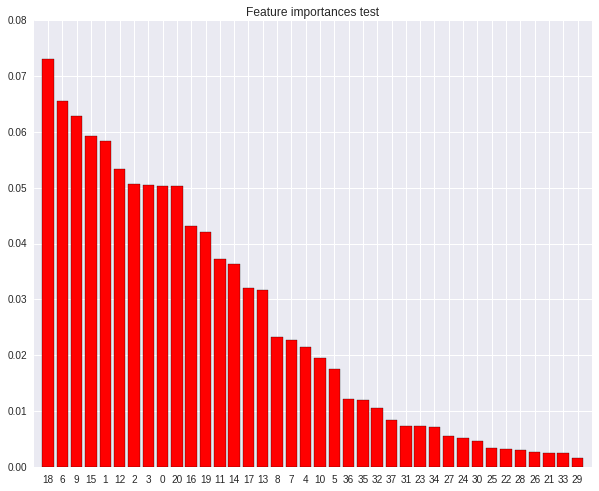

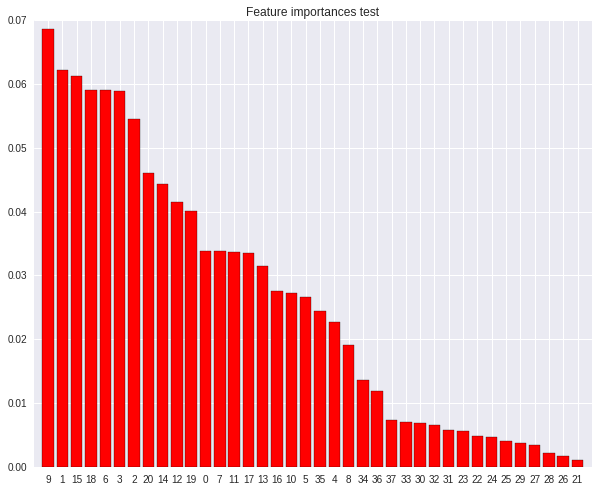

In [167]:
error_test,features_importances_test=evaluate_random_forest_model(X_train,X_test,y_train,y_test,return_feature_importances=True)
error_train,features_importances_train=evaluate_random_forest_model(X_train,X_train,y_train,y_train,return_feature_importances=True)
print('The percentage of errors in the test dataset with the model trained in the train dataset is:',error_test)
print('The percentage of errors in the train dataset with the model trained in the train dataset is:',error_train)
print('\n\n')
for i,feature in enumerate(X_train.columns.values):
    print('Column '+str(i)+':\t',feature)

indices = np.argsort(features_importances_test)[::-1]
plt.figure()
plt.title("Feature importances test")
plt.bar(range(X_train.shape[1]), features_importances_test[indices],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

indices = np.argsort(features_importances_train)[::-1]
plt.figure()
plt.title("Feature importances test")
plt.bar(range(X_train.shape[1]), features_importances_train[indices],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

As you can see the difference in overfitting is very high: with the default parameters the model strongly overfit in the training dataset.

About the feature\_importances\_ property, from the shown plot, it seems that the dummy variables are the less important. However there is not a group of features clearly more important than the others. More analysis will be done using the cross validation.

## Parameter variation to estimate overfitting

In this section we will plot learning curves to show how the overfitting issue varies with different parameters.
We study 2 parameters:
- max\_depth
- n\_estimators

As you can see, with a lower max_depth than the default the overfitting is less pronounced (it actually becomes 0 with very low values).

For the n_estimators parameter, instead, it does not vary significantly.

In [105]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)


### max_depth analysis

In [108]:
error_train=[]
error_test=[]
for i in range(1,20):
    error_test.append(evaluate_random_forest_model(X_train,X_test,y_train,y_test,max_depth=i))
    error_train.append(evaluate_random_forest_model(X_train,X_train,y_train,y_train,max_depth=i))


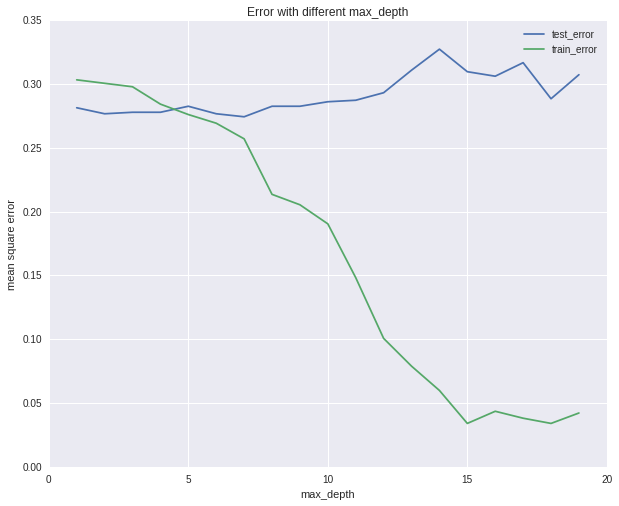

In [109]:
plt.plot(range(1,20),error_test)
plt.plot(range(1,20),error_train)
plt.legend(['test_error','train_error'])
plt.title('Error with different max_depth')
plt.xlabel('max_depth')
plt.ylabel('mean square error')

### n_estimators analysis

In [111]:
error_train=[]
error_test=[]
for i in range(1,40):
    error_test.append(evaluate_random_forest_model(X_train,X_test,y_train,y_test,n_estimators=i))
    error_train.append(evaluate_random_forest_model(X_train,X_train,y_train,y_train,n_estimators=i))


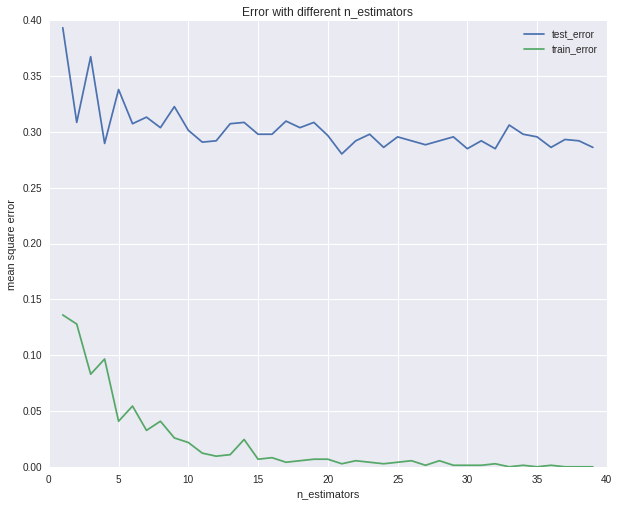

In [112]:
plt.plot(range(1,40),error_test)
plt.plot(range(1,40),error_train)
plt.legend(['test_error','train_error'])
plt.title('Error with different n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('mean square error')

## Cross validation

**COMMENTS**

We introduce now cross validation to get more precise results, choosing **n_folds=20**:

In [127]:
kf = KFold(X_train.shape[0]+X_test.shape[0], n_folds=20, shuffle=True)

In [216]:
def cross_val(database,features_to_remove=[],feature_importances=False,n_estimators=10,criterion='gini',
                                max_depth=None,min_samples_split=2, min_samples_leaf=1, 
              min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, 
              bootstrap=True, oob_score=False, n_jobs=1, random_state=None, 
              verbose=0, warm_start=False, class_weight=None):
    
    error_train=[]
    error_test=[]
    feature_importances_train=[]
    feature_importances_test=[]
    for iteration, data in enumerate(kf, start=1):

        X_train,X_test,y_train,y_test=process_database(database,train_indexes=data[0],test=True,binary_y=True)
        X_train=X_train.drop(features_to_remove,axis=1)
        X_test=X_test.drop(features_to_remove,axis=1)
        error_test_=evaluate_random_forest_model(X_train,X_test,y_train,y_test,
                                                        return_feature_importances=feature_importances,
                                                       n_estimators=n_estimators,criterion=criterion,
                                                       max_depth=max_depth,min_samples_split=min_samples_split, 
                                                       min_samples_leaf=min_samples_leaf, 
                                                       min_weight_fraction_leaf=min_weight_fraction_leaf, 
                                                       max_features=max_features, max_leaf_nodes=max_leaf_nodes, 
                                                       bootstrap=bootstrap, 
                                                       oob_score=oob_score, n_jobs=n_jobs, random_state=random_state, 
                                                       verbose=verbose, warm_start=warm_start, 
                                                       class_weight=class_weight)
        if feature_importances:
            error_test_,feat_imp_test_=error_test_
        error_train_=evaluate_random_forest_model(X_train,X_train,y_train,y_train,
                                                        return_feature_importances=feature_importances,
                                                        n_estimators=n_estimators,criterion=criterion,
                                                       max_depth=max_depth,min_samples_split=min_samples_split, 
                                                       min_samples_leaf=min_samples_leaf, 
                                                       min_weight_fraction_leaf=min_weight_fraction_leaf, 
                                                       max_features=max_features, max_leaf_nodes=max_leaf_nodes, 
                                                       bootstrap=bootstrap, 
                                                       oob_score=oob_score, n_jobs=n_jobs, random_state=random_state, 
                                                       verbose=verbose, warm_start=warm_start, 
                                                       class_weight=class_weight)
        if feature_importances:
            error_train_,feat_imp_train_=error_train_
        
            feature_importances_train.append(feat_imp_train_)
            feature_importances_test.append(feat_imp_test_)
        error_test.append(error_test_)
        error_train.append(error_train_)
        
    if feature_importances:
        return np.mean(error_train),np.mean(error_test),np.mean(feature_importances_train,axis=0),np.mean(feature_importances_test,axis=0)
    else:
        return np.mean(error_train),np.mean(error_test)


## Training parameters

In this section we train the Random Forest classifier with different parameters in order to find the best ones.
We did not remove any feature for this part.

### max_depth

In [136]:
error_train=[]
error_test=[]
# for i in np.linspace(0,0.5,40):
for i in range(2,20):
    error_train_,error_test_=cross_val(train_after_prep_2,max_depth=i)
    error_train.append(error_train_)
    error_test.append(error_test_)
    if i%1==0:
        print(i)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


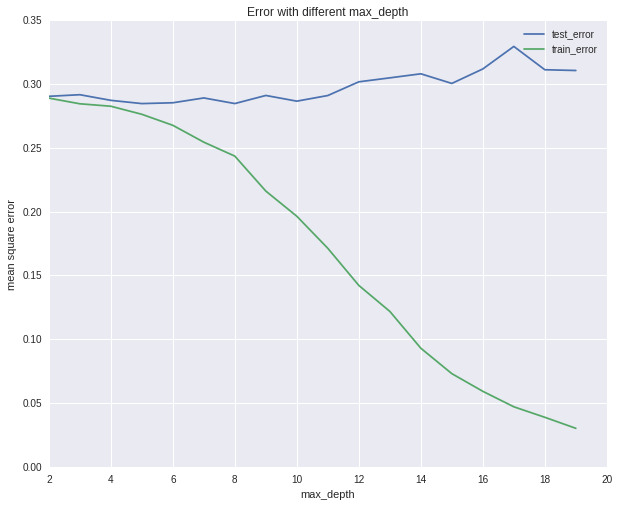

In [139]:
plt.plot(range(2,20),error_test)
plt.plot(range(2,20),error_train)
plt.legend(['test_error','train_error'])
plt.title('Error with different max_depth')
plt.xlabel('max_depth')
plt.ylabel('mean square error')

In [213]:
argmin=np.argmin(error_test)
best_par=range(2,20)[argmin]
print('The best parameter found is max_depth =',best_par)

The best parameter found is max_depth = 4


### n_estimators

In [217]:
error_train=[]
error_test=[]
for i in range(1,20):
    error_train_,error_test_=cross_val(train_after_prep_2,n_estimators=i)
    error_train.append(error_train_)
    error_test.append(error_test_)
    if i%5==0:
        print(i)


5
10
15


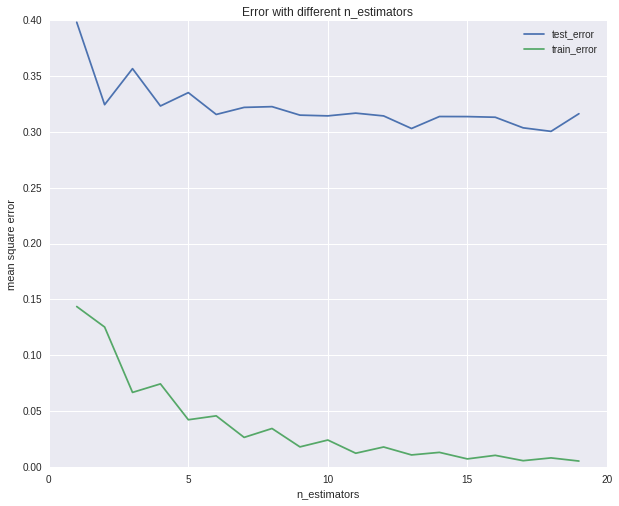

In [218]:
plt.plot(range(1,20),error_test)
plt.plot(range(1,20),error_train)
plt.legend(['test_error','train_error'])
plt.title('Error with different n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('mean square error')

In [219]:
argmin=np.argmin(error_test)
best_par=range(1,20)[argmin]
print('The best parameter found is n_estimators =',best_par)

The best parameter found is n_estimators = 18


### criterion

In [223]:
error_train=[]
error_test=[]

error_train_,error_test_=cross_val(train_after_prep_2,criterion='gini')

error_train.append(error_train_)
error_test.append(error_test_)

error_train_,error_test_=cross_val(train_after_prep_2,criterion='entropy')

error_train.append(error_train_)
error_test.append(error_test_)

In [224]:
argmin=np.argmin(error_test)
print('The error for the gini criterion is:',error_test[0])
print('The error for the entropy criterion is:',error_test[1])
print('The best criterion found is ',list(['gini','entropy'])[argmin])

The error for the gini criterion is: 0.30121835443
The error for the entropy criterion is: 0.300585443038
The best criterion found is  entropy


In [ ]:
error_train

In [ ]:
error_test

## Best parameters so far

In [212]:
(sum(y_test==1)+sum(y_train==1))/(len(y_test)+len(y_train))

0.29166666666666669

In [225]:
cross_val(train_after_prep_2,max_depth=5,n_estimators=18,criterion='gini')

(0.27811024422138975, 0.28795886075949367)

## Removing less important features

**COMMENTS**

In order to remove the less important features we proceeded in this way:
- We evaluate a particular configuration through a cross validation process;
- We observe the relative features\_importances\_ parameter;
- We remove the less important feature (lowest importance score);
- We iterate until we have removed 15 out of **40** (recosider) features.

Error: 0.291740506329
Removed feature from the next iteration: position_Left Midfielder


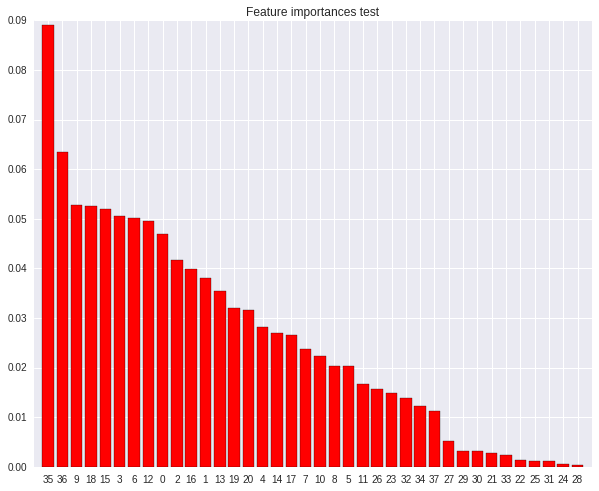

------------------------------------------------------------------
Error: 0.290482594937
Removed feature from the next iteration: position_Right Midfielder


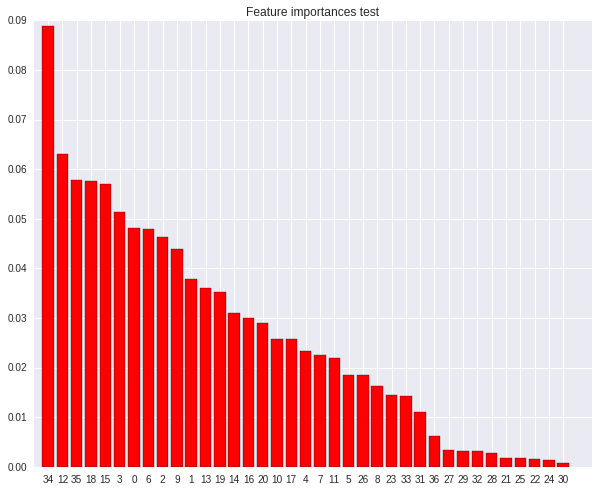

------------------------------------------------------------------
Error: 0.28605221519
Removed feature from the next iteration: position_Center Midfielder


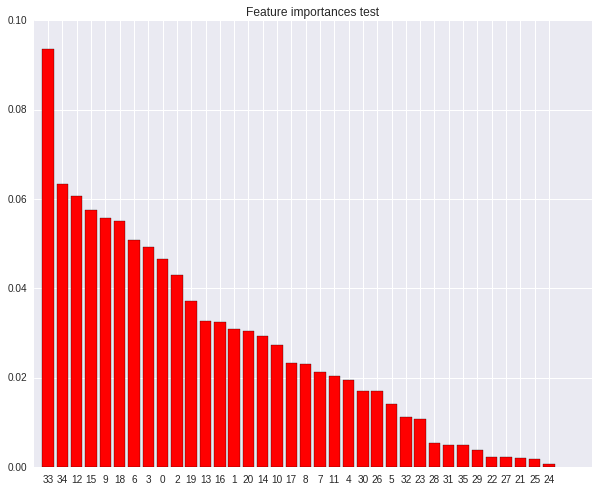

------------------------------------------------------------------
Error: 0.291107594937
Removed feature from the next iteration: position_Center Back


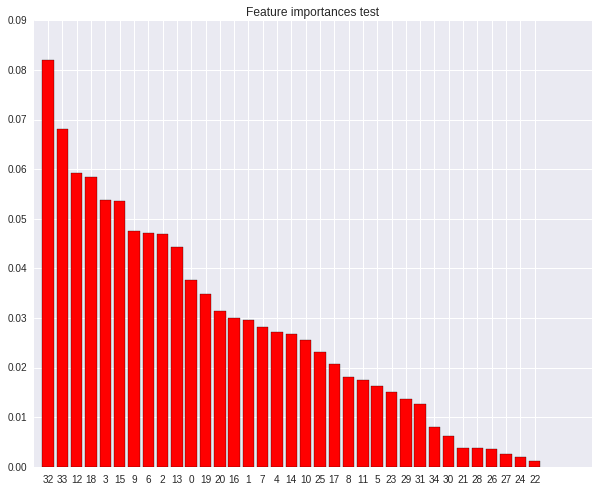

------------------------------------------------------------------
Error: 0.286693037975
Removed feature from the next iteration: position_Defensive Midfielder


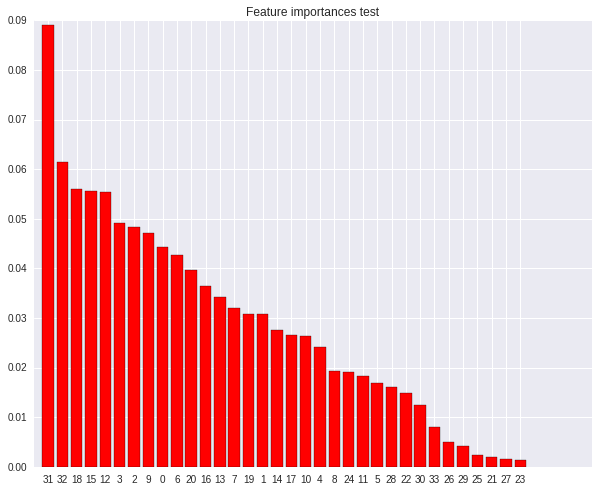

------------------------------------------------------------------


In [204]:
error_test=[]
error_train=[]

features_to_remove=[]
features_names=list(X_train.columns.values)

while len(features_to_remove)<5:
    error_train_,error_test_,features_importances_train,features_importances_test=cross_val(train_after_prep_2,
                                                             features_to_remove=features_to_remove,
                                                            max_depth=5,
                                                            feature_importances=True)
    worst_feature_index=np.argmin(features_importances_test)
    worst_feature=features_names[worst_feature_index]
    features_to_remove.append(worst_feature)
    del features_names[worst_feature_index]
    error_test.append(error_test_)
    error_train.append(error_train_)
    
    print('Error:',error_test_)
    print('Removed feature from the next iteration:',worst_feature)
    
    indices = np.argsort(features_importances_test)[::-1]
    plt.figure()
    plt.title("Feature importances test")
    plt.bar(range(X_train.shape[1]-len(features_to_remove)+1), features_importances_test[indices],
           color="r", align="center")
    plt.xticks(range(X_train.shape[1]-len(features_to_remove)+1), indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

    print('------------------------------------------------------------------')
    

In [193]:
features_importances_train

array([ 0.05007491,  0.05263981,  0.05598345,  0.05784194,  0.02682006,
        0.02325486,  0.06095947,  0.02581197,  0.02295367,  0.06358599,
        0.02623102,  0.02564054,  0.06206755,  0.03536011,  0.03677456,
        0.05658535,  0.03709364,  0.03296495,  0.06387962,  0.03790143,
        0.03737112,  0.00378496,  0.00452004,  0.0098114 ,  0.00215812,
        0.00342649,  0.00341595,  0.00613049,  0.00269129,  0.00484017,
        0.00427438,  0.00262158,  0.00725712,  0.00337547,  0.00884644,
        0.0201809 ,  0.01445284,  0.00641633])